<font size=6>**DL CNNs**</font> </h6>

In this session we dive into one of the most commonly used applications of DL which corresponds to the **Convolutional Neural Networks**. We will use mock images to classify galaxies, QSOs, and stars. <br>
The goals are:

- to get a grasp of what **CNNs are** 
- to **build and train** a DL network
- apply **trasnfer learning**

# A small introduction

## What are Convolutional Neural Networks (CNN)

> Is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. <br>
>
> _[A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way, by Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)_

## Example of CNN architecture

![CNN_schematic](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

The design of CNN allows to apply similar concepts to Neural Networks with special data processing techniques on data and between layers to learn from image data. 

## Components

**Convolutional Layers**

The convultion in CNNs is a technique inspired by the organization of the visual cortex, as neurons respond to stimulius in a given field of view. The convolution is a way to propogate information from nearby pixels in an image. 

The aim of CNN is to **reduce the dimensions** and **keep the importan features** that help in good predictions.  

Essentially a convolution is a matrix multiplication between the image and a *kernel* (another matrix, smaller than the image). Note, the shape of your input data has changed after going through the convolution (_'valid padding'_, in contrast to _'same padding'_ where the original dimensions are kept)

<div style="text-align: center;">
<img src="images/kernel_snapshot.png"> </img>
    </div>

![convolution](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)
<div style="text-align: center;">
Convoluting a 5x5x1 image with a 3x3x1 kernel to get a 3x3x1 convolved feature. The kernel (shown in yellow) takes into account only the pixels in the two diagonals (marked as 'x1' in the lower right corner of the yellow matrix). Therefore, in the first (frozen) image there are 9 pixels with the kernel considering 5 of them with values : 1+1+0+1+1 = 4 (the value trasnfered to the convoled feature).
</div>

The kernel is not necessary to move one pixel at a time. By chaning the _stride_ we can select any kind of movement, which includes both the width and the height. A (1,1) stride will move one pixel right (stating always from the top left corner) and after completing the row it will move one pixel down (and left again). A (2,2 will do the similar thing but with two pixels moves. Hoever, in this case we also **downsampling** the extracted feature. 

**Activaltion function**

The function used to impose a non-linear transformation to the input data. Perhaps the most typical one used is the ReLU (Rectified Linear Unit), which has the advantage of not activating all neurosn at the same time.  

**Pooling**

Sometimes data is big and we want to speed up the process. Can we *pool* some cells together to reduce our data size between convolutions? Yes! The technique is called (obviously...) _pooling_ and it can be performed by either taking the average of all the pixels that the pooling layer is over the feature layer (**average pooling**) or the maximum value found in any of the pixels (**max pooling**). 

![pooling_2](https://miro.medium.com/max/1192/1*KQIEqhxzICU7thjaQBfPBQ.png)
<div style="text-align: center;">
Examples of max and average pooling. 
</div>

![pooling_1](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)
<div style="text-align: center;">
A 3x3 max pooling acting over a 5x5 feature map. 
</div>

The benefits of pooling layers are: i. the **decrease of dimensions** that help the decrease the computational power, ii. they extract the most **dominant features which are rotational and positional invariant**. 

There are two flavors of pooling layers, either local (with dimensions smaller that the feature dimensions) or _global_ that act on the whole feature layer (and they actually convert it to a single value), which is more aggressive. 

**Fully connected layers**

Once input images have been convolved and reduced into an appropriate size, they can be pushed through a fully connected layer into the familiar NN architecture. This layer learns converts all high-level features as identified from the previous part of the network into the final output (classes) 

**Dropout**

One way to prevent overfitting is the dropout method - remove individual nodes from the network (with some probability) at each training stage. This could be at the level of the input node or at hidden layers.

**Batch Normalization**

Each layer's weights (and therefore outputs) are updated every training iteration. More layers can mean larger changes down the network (nonlinear behavior), for small changes in weights, so small learning rates may be needed which makes training hard. Instead we may enforce each layer to prduce **predictable** output from layer to layer using batch normalization giving more stable behavior and reducing training time. Predictbale in this case means that the distribution of outputs from the previous layer has specific properties: unit variance, zero mean. In other words it is a technique to standardize the input to a layer. ([Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167))

(Source: images and material mostly from [this web article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).



**Example classification networks**

AlexNet & LeNet: image classification networks - "In ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2010, AlexNet was trained to classify 1.2 million high-resolution images into 1000 different classes. It achieved top-1 and top-5 error rates of 37.5% and 17%, which outperforms state-of-the-art methods at that time." [article](https://medium.com/mlearning-ai/alexnet-and-image-classification-8cd8511548b4)
    
![example network architectures](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

## Visualization of layers

[Link 1](https://poloclub.github.io/cnn-explainer/)

[Link 2](https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html)

# Galaxy morphology estimation

**TASK 1: Build a network to classify stars, spiral and elliptical galaxies from synthetic data with noise.**

## Load necessary libraries

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import keras
from IPython.display import clear_output
import keras.utils as ult
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time

## Define an auxiliary function to plot the accuracy and loss value during training

In [49]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get('categorical_accuracy'))
        self.val_losses2.append(logs.get('val_categorical_accuracy'))

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Training accuracy",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Validation accuracy",linestyle='--')
        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Training loss",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Validation loss",linestyle='--')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
def show_images(images,galaxy_labels):
    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[0]))
    plt.imshow(images[0,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[0,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[0,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[1]))
    plt.imshow(images[1,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[1,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[1,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[5]))
    plt.imshow(images[5,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[5,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[5,:,:,2], vmax=255)
    plt.axis('off')

In [4]:
def label_trans(label_id):
    if label_id==0: return "star"
    if label_id==1: return "spiral galaxy"
    if label_id==2: return "elliptical galaxy"
    else: return "unknown"  

## Load the data

**data**: are images at different wavelenghts i.e. 3D with 2 spatial (41x41 pixels) and 1 spectral (3 bands) dimension     
**labels**: take values 0: star, 1: spiral galaxy, 2: elliptical galaxy   

[(10000, 41, 41, 3), (10000,)]


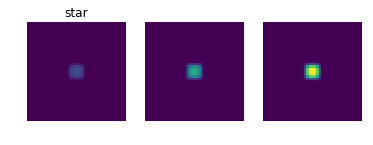

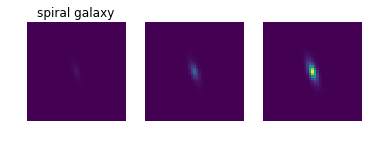

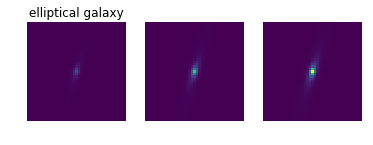

In [5]:
with np.load('data/galaxy_cubes.npz') as data:
    images = data['images']
    galaxy_labels = data['labels']

print([images.shape, galaxy_labels.shape])

show_images(images,galaxy_labels) 

## Add white noise to observations

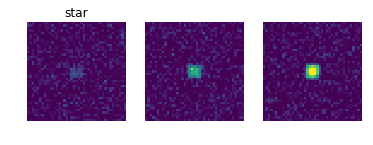

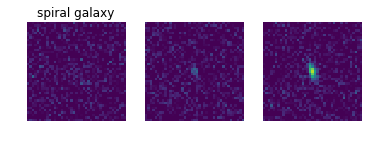

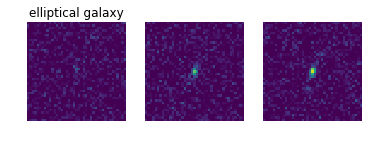

In [6]:
images= images+np.random.randn(10000,41,41,3)*20
images= np.clip(images, 0, 255)

show_images(images,galaxy_labels) 

# Model

## Create training and testing (validation) dataset

_HINT:_ to test various architectures fast keep the train/test sizes rather **small**, i.e. use a huge fraction for test to get a very small number for train+validation (a few hundrends). At the end you would like to retrain with the **full dataset** (that will take some time).

In [81]:
# X is for data and y for labels... 

# first split to get the test data, and X_train_full which is both train+validation
# you can use random_state if you want to reproduce the same exact splits
# and shuffle if you want to mix the data before splits

X_train_full, X_test_img, y_train_full, y_test = train_test_split(
        images,galaxy_labels, test_size=0.95) #, shuffle = True, random_state=42)

# split into train and validation
X_train_img, X_valid_img, y_train, y_valid = train_test_split(
        X_train_full, y_train_full, test_size=0.3) #, shuffle = True, random_state=24 )

print(f'From {len(images)} images, we use as:')
print(f'test: \t\t {len(X_test_img)}')
print(f'train: \t\t  {len(X_train_img)}')
print(f'validation:\t  {len(X_valid_img)}')
      

From 10000 images, we use as:
test: 		 9500
train: 		  350
validation:	  150


In [83]:
# NOTE: this is a data manipulation as keras needs the number of objects 
# with properties at each "channel", and their correspoding number. 
# As keras thinks of images as RGB it uses 3 as last number. 
# To avoid keras to assume anything add specifically ',1' at the end.

X_train = X_train_img.reshape(len(X_train_img), images.shape[1],images.shape[2],images.shape[3],1)
X_valid = X_valid_img.reshape(len(X_valid_img), images.shape[1],images.shape[2],images.shape[3],1)
X_test  = X_test_img.reshape(len(X_test_img), images.shape[1],images.shape[2],images.shape[3],1)


# NOTE: converting labels to categorical representation  
y_train_cat = ult.to_categorical(y_train,num_classes=3)
y_valid_cat = ult.to_categorical(y_valid,num_classes=3)
y_test_cat  = ult.to_categorical(y_test,num_classes=3)

## Define network layers and characteristics


In [91]:
inputs = Input((images.shape[1], images.shape[2], images.shape[3], 1),name='main_input')

conv00  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv00')(inputs)
#bn00 = BatchNormalization()(conv00)
act00 = Activation('relu')(conv00)
pool00  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act00)


conv10  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv10')(pool00)
#bn10 = BatchNormalization()(conv10)
act10 = Activation('relu')(conv10)
#add00 = Add()([pool00,act10])
pool10  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act10)


conv20  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv20')(pool10)
#bn20 = BatchNormalization()(conv20)
act20 = Activation('relu')(conv20)
#add20 = Add()([pool10,act20])
pool20  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act20)

fl0 = Flatten(name='fl0')(pool20)
#Do0 = Dropout(rate=0.5)(fl0)
fc0 = Dense(32,activation='linear')(fl0)
#Do1 = Dropout(rate=0.5)(fc0)
fc1 = Dense(8,activation='linear')(fc0)
#Do2 = Dropout(rate=0.5)(fc1)

# ALTERNATIVE architecture
# conv00  = Conv3D(128, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv00')(inputs)
# act00 = Activation('relu')(conv00)
# pool00  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act00)

# conv10  = Conv3D(64, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv10')(pool00)
# act10 = Activation('elu')(conv10)
# pool10  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act10)

# conv20  = Conv3D(32, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv20')(pool10)
# act20 = Activation('relu')(conv20)
# pool20  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act20)

# fl0 = Flatten(name='fl0')(pool00)
# Do0 = Dropout(rate=0.5)(fl0)
# fc0 = Dense(8,activation='linear')(fl0)

Dn0 = Dense(3,activation='softmax', name='Dn0' )(fc1)

my_model = Model(inputs=[inputs], outputs=[Dn0])

## Select optimizer and compile the model

_HINT:_ check the documentation ([keras:accuracy_metrics](https://keras.io/api/metrics/accuracy_metrics/)) and remember that we are using the one-hot labels. 

In [92]:
optzr =  Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=0.0)
my_model.compile(loss='categorical_crossentropy', optimizer=optzr, metrics =['categorical_accuracy'])
my_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 41, 41, 3, 1)      0         
_________________________________________________________________
conv00 (Conv3D)              (None, 41, 41, 3, 16)     304       
_________________________________________________________________
activation_10 (Activation)   (None, 41, 41, 3, 16)     0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 21, 21, 3, 16)     0         
_________________________________________________________________
conv10 (Conv3D)              (None, 21, 21, 3, 16)     4624      
_________________________________________________________________
activation_11 (Activation)   (None, 21, 21, 3, 16)     0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 11, 11, 3, 16)     0   

## Train the network



_HINT:_ to test training fast keep the **batch_size larger**, and the **epochs smaller**. 

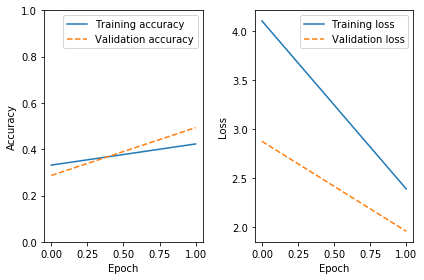

'00:00:19'

In [93]:
start_time = time.time() 
                                                    
history=my_model.fit(X_train, y_train_cat,    # batchsze =20, epochs =50
                    batch_size=32, 
                    epochs=2,
                    validation_data=[ X_valid, y_valid_cat],
                    callbacks=[plot_losses],shuffle=True)
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

## Check performance

_HINT_: if you want to speed up the process a bit select the number of TO objects of the test set

In [94]:
TO = len(X_test) # or smaller...

ls,acc=my_model.evaluate( X_test[0:TO], y_test_cat[0:TO])  
print("Loss value: %.2f" % (ls))  
print("Accuracy: %.1f" % (acc*100))   

9500/9500 [==============================] - 11s 1ms/step
Loss value: 1.82
Accuracy: 51.1


## Predict label for particular example

In [119]:
# select object
obj = 3        # must be < len( X_test)

preds = my_model.predict( X_test[obj:obj+1,:,:,:,:])
print(f"Probability per class: {', '.join([str(i*100)[0:5]+'%' for i in preds[0]])}")
print(f'Highest for class: {label_trans( y_test[obj])}')


Probability per class: 78.26%, 0.008%, 21.72%
Highest for class: star


## Use intemediate layers as outputs

_HINT_: use model.layers to print all layers of the model, and select which ones you want as an output.

In [122]:
my_model.layers

In [123]:
lr1=my_model.layers[1].output  
lr2=my_model.layers[4].output
lr3=my_model.layers[7].output

activation_model_lr1 = Model(inputs=[inputs], outputs=lr1)
activation_model_lr2 = Model(inputs=[inputs], outputs=lr2)
activation_model_lr3 = Model(inputs=[inputs], outputs=lr3)


## Print the activations for particular inputs

In [125]:
my_model.layers[1]

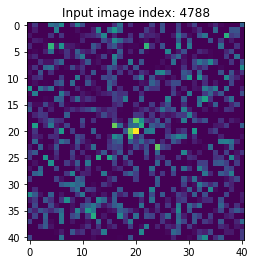

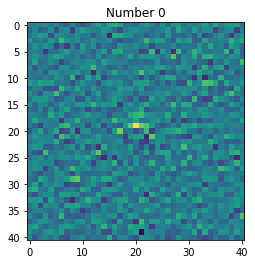

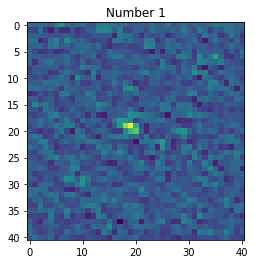

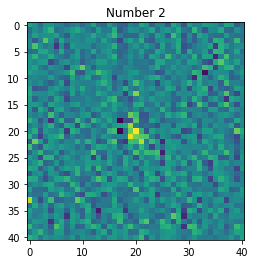

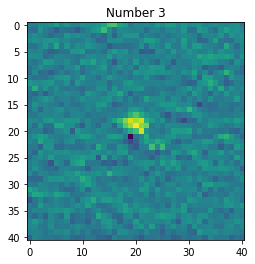

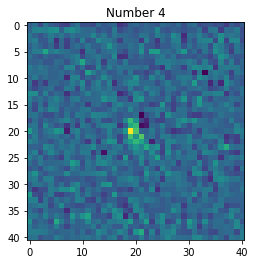

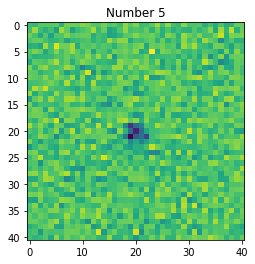

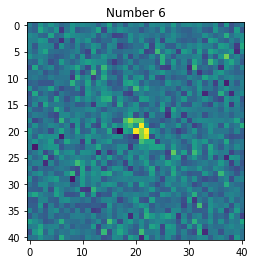

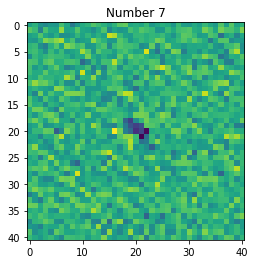

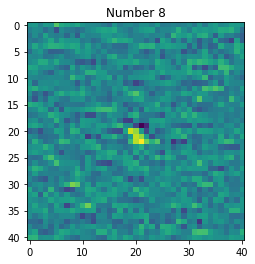

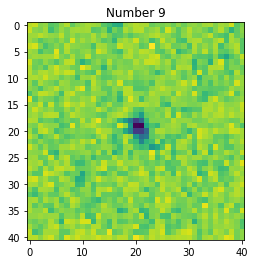

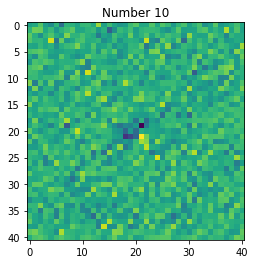

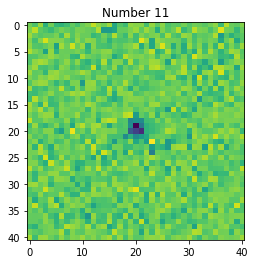

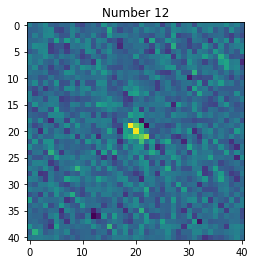

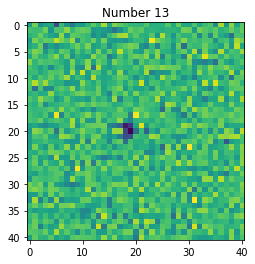

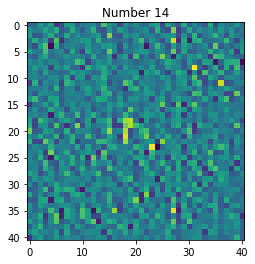

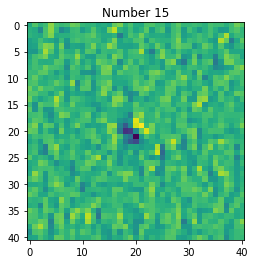

In [128]:
s = np.random.randint(0,len(X_test)-1)

plt.imshow(X_test[s,:,:,0,0])
plt.title(f'Input image index: {s}')
plt.show()

# NOTE: in the following select convolution layers
activations_lr1 = activation_model_lr1.predict( X_test[s:s+1,:,:,:,:]) 
# activations_lr2 = activation_model_lr2.predict( X_test[s:s+1,:,:,:,:]) 
# activations_lr3 = activation_model_lr2.predict( X_test[s:s+1,:,:,:,:]) 

# NOTE: check the number of nodes in the CNN
for i in np.arange(16):
    img=activations_lr1[0,:,:,0,i]
    plt.imshow(img)
    plt.title('Number ' + str(i))
    plt.show()
plt.show()

# Transfer Learning

<div style="text-align: center;">
<img src="images/ResNet-50-architecture.png"> 
Figure 4.1. The ResNet-50 architecture. <br>
(Credit: <a href="https://www.researchgate.net/figure/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and_fig1_338603223"
 target="_blank" rel="noopener noreferrer">source</a>)
    </img>
    </div>


In [129]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [130]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(205, 205, 3))

FC_LAYERS = [256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=3)

finetune_model.summary()


/home/grigoris/.local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 205, 205, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 211, 211, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 103, 103, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 103, 103, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Resize the data

_HINT_: start with a smaller number of images (a few hundreds) to create the new images, and then increase that

In [136]:
from PIL import Image
n_new_imgs = 100  # 3000
images2=np.empty([n_new_imgs,205,205,3])
for i in range(n_new_imgs):
    for c in range(3):
        tmp=images[i,:,:,c]
        img = Image.fromarray(tmp)
        img2 = img.resize((205,205),Image.BICUBIC)
        images2[i,:,:,c]=img2    

#show_images(images2)

In [156]:
# for faster computation time we select a number of initial images that we reshape
train_fraction = 0.7

num_train = int(n_new_imgs*train_fraction)
num_valid = int((n_new_imgs-num_train)/2)
num_test = num_valid

X_train_rs = images2[0:num_train,:,:,:]
X_valid_rs = images2[num_train:num_train+num_valid,:,:,:]
X_test_rs  = images2[num_train+num_valid:n_new_imgs,:,:,:]

y_train_rs = galaxy_labels[0:num_train]
y_valid_rs = galaxy_labels[num_train:num_train+num_valid]
y_test_rs  = galaxy_labels[num_train+num_valid:n_new_imgs]

y_train_cat_rs = ult.to_categorical(y_train_rs,num_classes=3)
y_valid_cat_rs = ult.to_categorical(y_valid_rs,num_classes=3)
y_test_cat_rs  = ult.to_categorical(y_test_rs,num_classes=3)

print('A few checks of what we did:')
print(f'- data to train: {X_train_rs.shape}')
print(f'- validation labels: {y_valid_rs.shape}, e.g. objetc 2: {y_valid_rs[2]}')
print(f'- test categorical labels: {y_valid_cat_rs.shape}, e.g. object 2: {y_valid_rs[2]} ')

A few checks of what we did:
- data to train: (70, 205, 205, 3)
- validation labels: (15,), e.g. objetc 2: 1.0
- test categorical labels: (15, 3), e.g. object 2: 1.0 


## Fine-tune pre-trained model

_HINT:_ to test training fast keep the batch_size larger, and the epochs smaller 

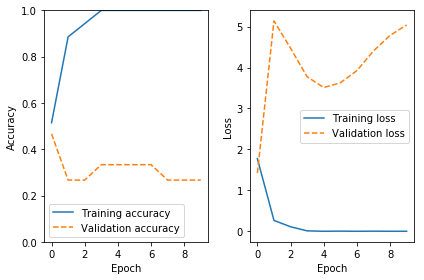

In [157]:
finetune_model.compile(optzr, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                                                                        
history = finetune_model.fit( X_train_rs, y_train_cat_rs, 
                             batch_size=20, 
                             epochs=10,
                             validation_data=[ X_test_rs, y_test_cat_rs],
                             callbacks=[plot_losses],shuffle=True)


## Check the performance

In [158]:
ls,acc = finetune_model.evaluate( X_test_rs, y_test_cat_rs)
print("Loss value: %.2f" % (ls))  
print("Accuracy: %.1f" % (acc*100))  

15/15 [==============================] - 1s 84ms/step
Loss value: 5.04
Accuracy: 26.7


## Try to answer these questions

**1. What do you notice?**
<br>
<details>
<summary>Click for answer</summary>
If the training accuracy is very close to 1 and the training loss always systematically under the validation loss then the model is overfitting!
    
Check <a href='https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/' target="_blank" rel="noopener noreferrer"> this site</a> for how to diagnosize the various cases.

</details>

**2. Can you guess why is happening**
<br>
<details>
<summary>Click for answer</summary>
There is a huge number of parameters (~50M) in this pretrained model that easily overfitts the data.
    
</details>